Q-learning:
- Behaviour Policy (ex: Random exploration)
- At current state after random action, calculate observed Q-value (bellman equation): new reward for action state + max q-value over all actions possible from that new state
- Calculate Temporal difference error: Observed - Expected
- Update with learning rate alpha: Q = Q+alpha*TD_error
One episode consists of running this until we reach a final state. Running a bunch of episodes is how the agent learns the whole Q-table

SARSA:
- Instead of observed Q-value being based on max of q value over all possible action, it is computed from the Q-value of the action to take in new state based on Behaviour Policy
- Summary: State action reward state action, with both actions determined by policy. Two consecutive state-action pairs determined by policy -> on policy reward



Notes
- Gymnasium assumes infinite deck with replacement ie constant probabilities
- Rewards only happen at the end of a round. Winning = +1, Losing = -1, Draw = 0
- Look into maximal expected reward: 99.5% of the bet. This means for every 1,000 games, the agent might win approximately 495 games, lose 495 games, and draw 10 games, assuming the rules are balanced and follow standard Blackjack house rules.


Questions for team:
- How to motivate / structure the report
- Within your own sections, what are you reporting and in what format? I will be finding the optimal parameters - learning rate, epsilon decay, number of episodes - graphs in notion
- Is there another method adjacent to any of yours you would like me to try?

Introduction:
- Lauren: 5 and the abstract
- Vlada: 1 and 2
- Yunran: 3 and 4
- Yanxu: 6 and 7
- By Sunday night: All code done + methodology
- Monday: Call 11:15 - Combine code with others, make graphs and discuss results
- Tuesday night: Finalise everything - all report

In [17]:
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from mpl_toolkits.mplot3d import Axes3D

In [55]:
def epsilon_greedy_policy(Q, state, epsilon, action_space):
    if random.uniform(0, 1) < epsilon:
        return action_space.sample()  # Explore
    else:
        return np.argmax(Q[state])  # Exploit

def sarsa(env, episodes=50000, alpha=0.1, gamma=0.99, epsilon=0.1, epsilon_min=0.01, epsilon_decay=0.995, use_epsilon_decay=False, log_interval=5000, plot_results=True):
    Q = np.zeros((32, 11, 2, env.action_space.n))  # State space
    rewards_per_episode = []
    episode_lengths = []
    training_errors = []

    wins, losses, draws = 0, 0, 0
    initial_avg_reward = None

    for episode in range(episodes):
        state, _ = env.reset()
        action = epsilon_greedy_policy(Q, state, epsilon, env.action_space)
        total_reward = 0
        done = False
        steps = 0
        prev_q = Q.copy()

        while not done:
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_action = epsilon_greedy_policy(Q, next_state, epsilon, env.action_space)

            # SARSA update rule
            Q[state][action] += alpha * (reward + gamma * Q[next_state][next_action] * (not done) - Q[state][action])

            state, action = next_state, next_action
            total_reward += reward
            steps += 1

        rewards_per_episode.append(total_reward)
        episode_lengths.append(steps)
        training_errors.append(np.sum(np.abs(Q - prev_q)))

        if total_reward > 0:
            wins += 1
        elif total_reward < 0:
            losses += 1
        else:
            draws += 1

        # Epsilon decay=
        if use_epsilon_decay:
            epsilon = max(epsilon_min, epsilon_decay * epsilon)

        # Record initial average reward
        if episode == 0:
            initial_avg_reward = np.mean(rewards_per_episode)

    final_avg_reward = np.mean(rewards_per_episode[-log_interval:])

    # Calculate win, loss, and draw percentages
    total_episodes = wins + losses + draws
    win_percentage = (wins / total_episodes) * 100 if total_episodes > 0 else 0
    loss_percentage = (losses / total_episodes) * 100 if total_episodes > 0 else 0
    draw_percentage = (draws / total_episodes) * 100 if total_episodes > 0 else 0

    print(f"Initial Avg Reward: {initial_avg_reward:.4f}")
    print(f"Final Avg Reward: {final_avg_reward:.4f}")
    print(f"Win Percentage: {win_percentage:.2f}%")
    print(f"Loss Percentage: {loss_percentage:.2f}%")
    print(f"Draw Percentage: {draw_percentage:.2f}%")

    if plot_results:
        fig, axs = plt.subplots(3, 1, figsize=(10, 12))

        # Reward Plot
        axs[0].plot(np.convolve(rewards_per_episode, np.ones(500)/500, mode='valid'))
        axs[0].set_xlabel('Episodes')
        axs[0].set_ylabel('Average Reward')
        axs[0].set_title('SARSA Training Progress')

        # Episode Length Plot
        axs[1].plot(np.convolve(episode_lengths, np.ones(500)/500, mode='valid'))
        axs[1].set_xlabel('Episodes')
        axs[1].set_ylabel('Episode Length')
        axs[1].set_title('Episode Length Over Time')

        # Training Error Plot
        axs[2].plot(np.convolve(training_errors, np.ones(500)/500, mode='valid'))
        axs[2].set_xlabel('Episodes')
        axs[2].set_ylabel('Training Error')
        axs[2].set_title('Training Error Over Time')

        plt.tight_layout()
        plt.show()

    return Q

# Play with policy
def play_blackjack(Q, env, episodes=1000):
    wins, draws, losses = 0, 0, 0

    for _ in range(episodes):
        state, _ = env.reset()
        done = False

        while not done:
            action = np.argmax(Q[state])  # Choose best action
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

        if reward > 0:
            wins += 1
        elif reward < 0:
            losses += 1
        else:
            draws += 1

    print(f"Wins: {wins}, Draws: {draws}, Losses: {losses}")

# Play randomly
def play_random(env, episodes=1000):
    wins, draws, losses = 0, 0, 0
    total_reward = 0

    for _ in range(episodes):
        state, _ = env.reset()
        done = False

        while not done:
            action = env.action_space.sample()  # Choose random action
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

        total_reward += reward

        if reward > 0:
            wins += 1
        elif reward < 0:
            losses += 1
        else:
            draws += 1

    avg_reward = total_reward / episodes
    print(f"Random Play - Wins: {wins}, Draws: {draws}, Losses: {losses}, Average Reward: {avg_reward:.4f}")

# Inspired by https://gymnasium.farama.org/tutorials/training_agents/blackjack_tutorial/
def visualize_policy(Q):
    dealer_range = range(1, 11)  # Dealer's showing card (1-10)
    player_range = range(12, 22)  # Player's hand sum (12-21)
    usable_ace = False  # Use `True` if you want to consider usable ace, else `False`

    player_count, dealer_count = np.meshgrid(player_range, dealer_range)
    value = np.apply_along_axis(
        lambda obs: float(np.max([Q[obs[0], obs[1], 0, 0], Q[obs[0], obs[1], 0, 1]])),
        axis=2,
        arr=np.dstack([player_count, dealer_count])
    )
    policy = np.apply_along_axis(
        lambda obs: int(np.argmax([Q[obs[0], obs[1], 0, 0], Q[obs[0], obs[1], 0, 1]])),
        axis=2,
        arr=np.dstack([player_count, dealer_count])
    )

    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle('Policy Visualization', fontsize=16)

    # 3D plot
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        player_count,
        dealer_count,
        value,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none",
    )
    ax1.set_xlabel("Player Sum")
    ax1.set_ylabel("Dealer Showing")
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.set_title("State Values")
    ax1.view_init(20, 220)

    # 2D policy plot
    ax2 = fig.add_subplot(1, 2, 2)
    cmap = sns.color_palette(['grey', 'lightgreen'], as_cmap=True)
    sns.heatmap(policy, linewidth=0, annot=True, cmap=cmap, cbar=False)
    ax2.set_xlabel("Player Sum")
    ax2.set_ylabel("Dealer Showing")
    ax2.set_xticks(np.arange(10) + 0.5)
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticks(np.arange(10) + 0.5)
    ax2.set_yticklabels(['A'] + list(range(2, 11)), fontsize=12)
    ax2.set_title("Policy: Green = Hit, Grey = Stick")

    legend_elements = [
        Patch(facecolor='lightgreen', edgecolor='black', label='Hit'),
        Patch(facecolor='grey', edgecolor='black', label='Stick')
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))

    plt.show()

In [8]:
env = gym.make("Blackjack-v1", natural=True, sab=True)

print("Action Space:", env.action_space)
print("Observation Space:", env.observation_space)
print("Sample State:", env.observation_space.sample())
print("Sample Action:", env.action_space.sample())

# Before training
play_random(env)

Action Space: Discrete(2)
Observation Space: Tuple(Discrete(32), Discrete(11), Discrete(2))
Sample State: (12, 0, 1)
Sample Action: 1
Random Play - Wins: 281, Draws: 39, Losses: 680, Average Reward: -0.3990


Initial Avg Reward: -1.0000
Final Avg Reward: -0.1200
Win Percentage: 40.39%
Loss Percentage: 51.32%
Draw Percentage: 8.29%


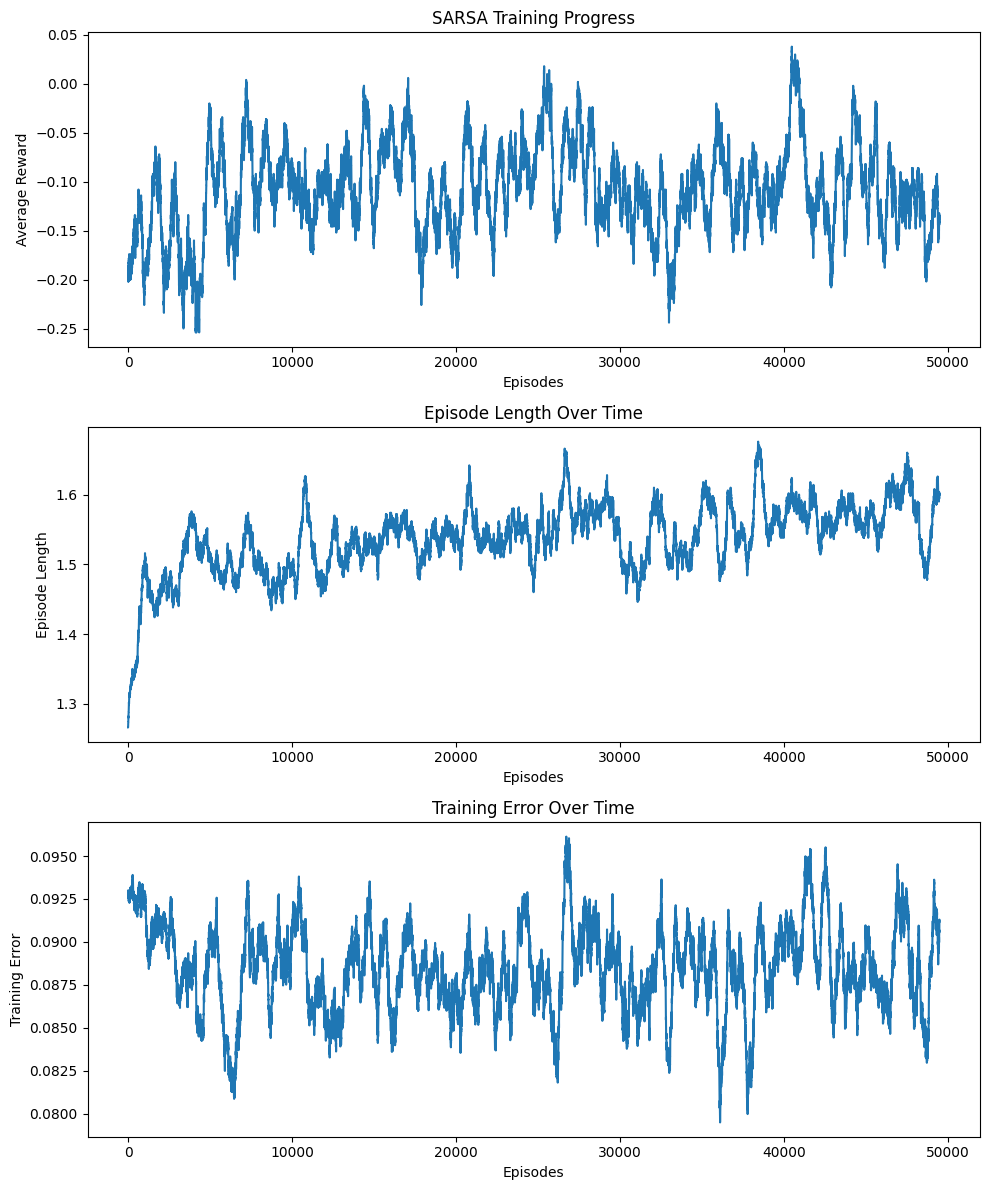

Wins: 438, Draws: 88, Losses: 474


In [9]:
Q = sarsa(env)
play_blackjack(Q, env)

Initial Avg Reward: -1.0000
Final Avg Reward: -0.1086
Win Percentage: 40.66%
Loss Percentage: 51.45%
Draw Percentage: 7.90%


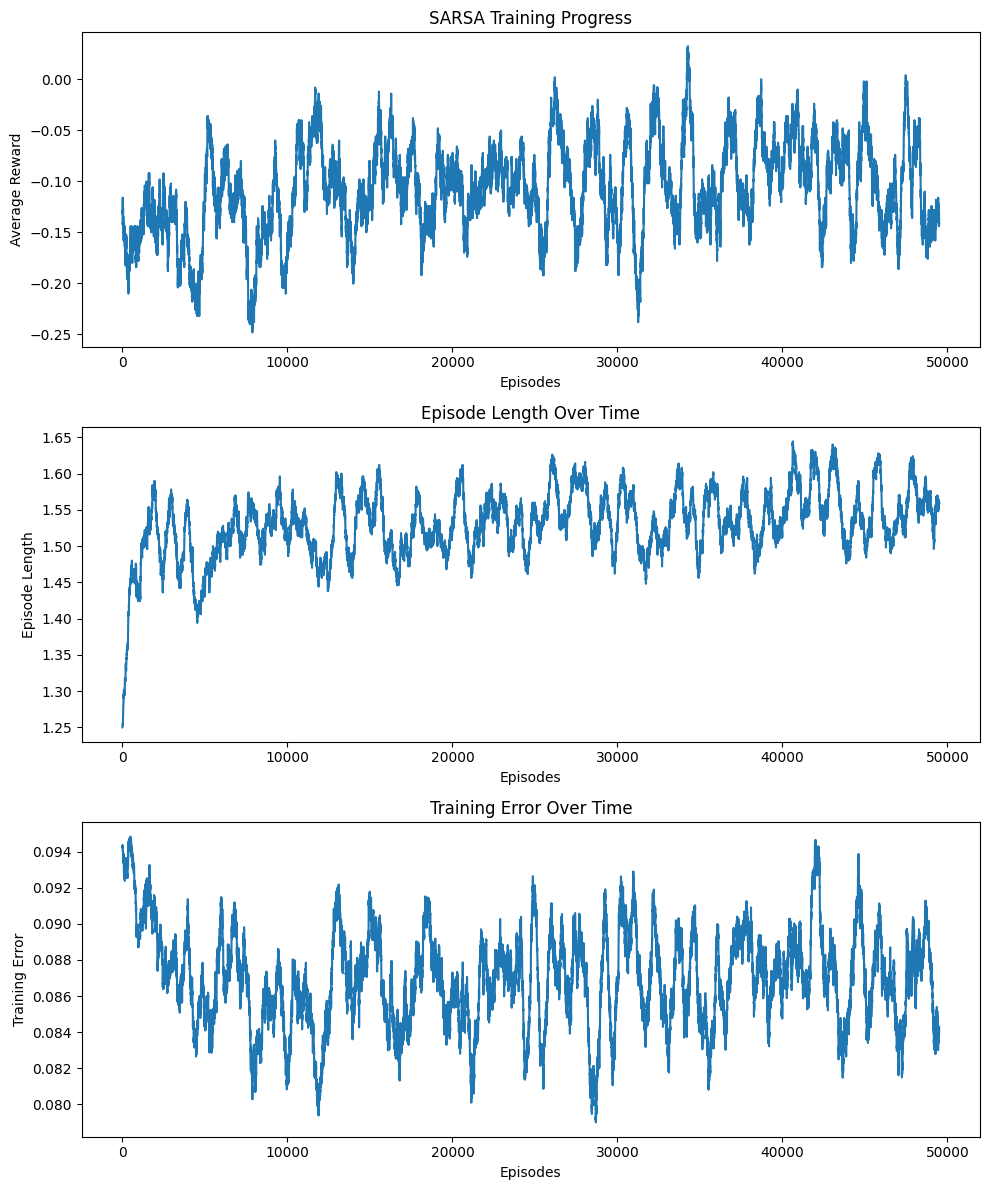

Wins: 451, Draws: 80, Losses: 469


In [10]:
# Reducing gamma to focus on immediate reward (winning, busting) - not much difference, could try more
Q = sarsa(env, gamma = 0.9)
play_blackjack(Q, env)

Initial Avg Reward: -1.0000
Final Avg Reward: -0.0602
Win Percentage: 42.45%
Loss Percentage: 48.99%
Draw Percentage: 8.56%


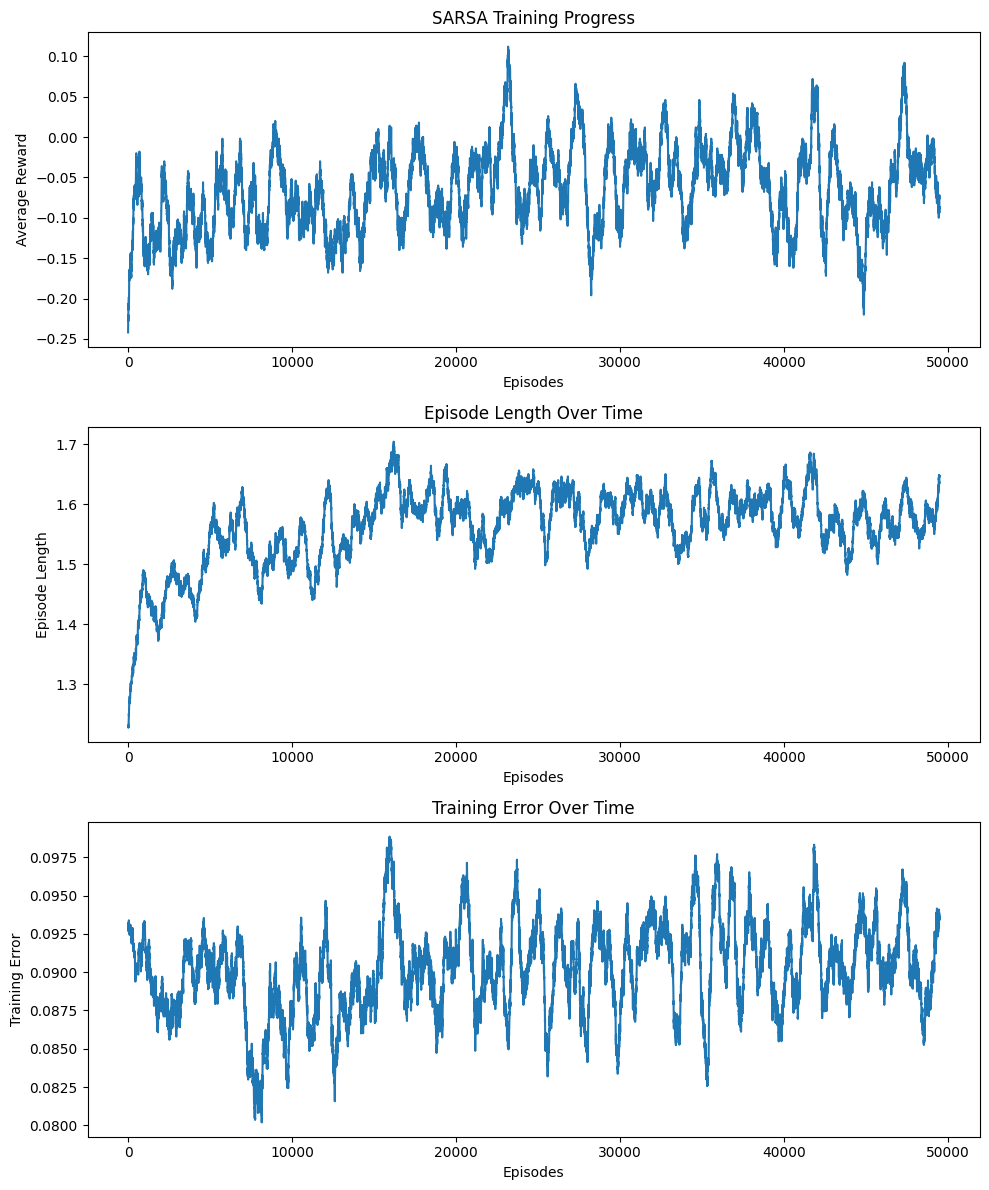

Wins: 454, Draws: 84, Losses: 462


In [11]:
# Adding epsilon decay so that the agent explores less as it refines the policy - greatly increases average reward! Try more values
Q = sarsa(env, use_epsilon_decay=True)
play_blackjack(Q, env)

Testing alpha=0.06
Initial Avg Reward: -1.0000
Final Avg Reward: -0.0678
Win Percentage: 42.05%
Loss Percentage: 49.31%
Draw Percentage: 8.64%


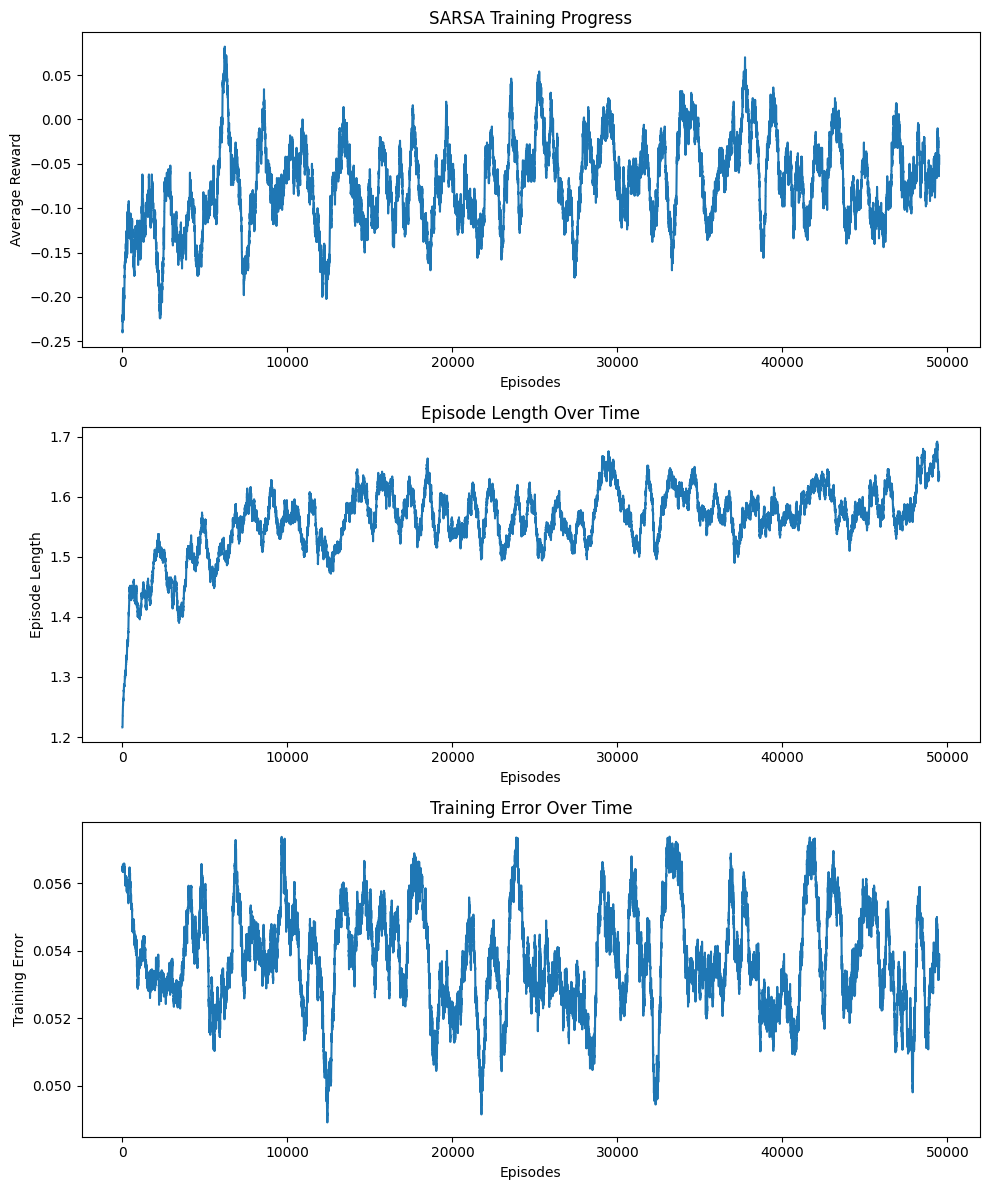

Wins: 418, Draws: 91, Losses: 491
Testing alpha=0.07
Initial Avg Reward: -1.0000
Final Avg Reward: -0.0814
Win Percentage: 41.96%
Loss Percentage: 49.22%
Draw Percentage: 8.82%


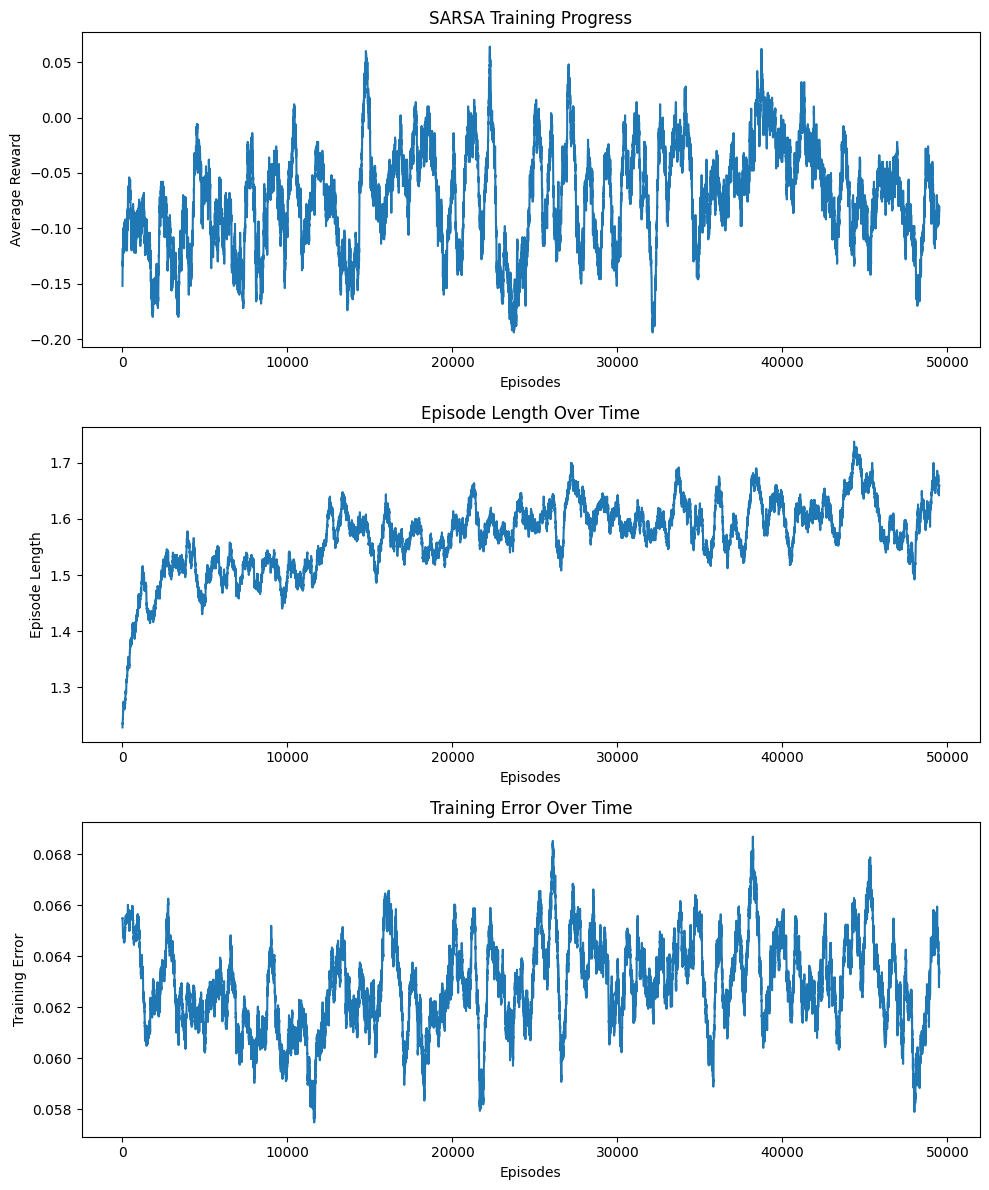

Wins: 426, Draws: 106, Losses: 468
Testing alpha=0.08
Initial Avg Reward: -1.0000
Final Avg Reward: -0.0546
Win Percentage: 41.85%
Loss Percentage: 49.85%
Draw Percentage: 8.30%


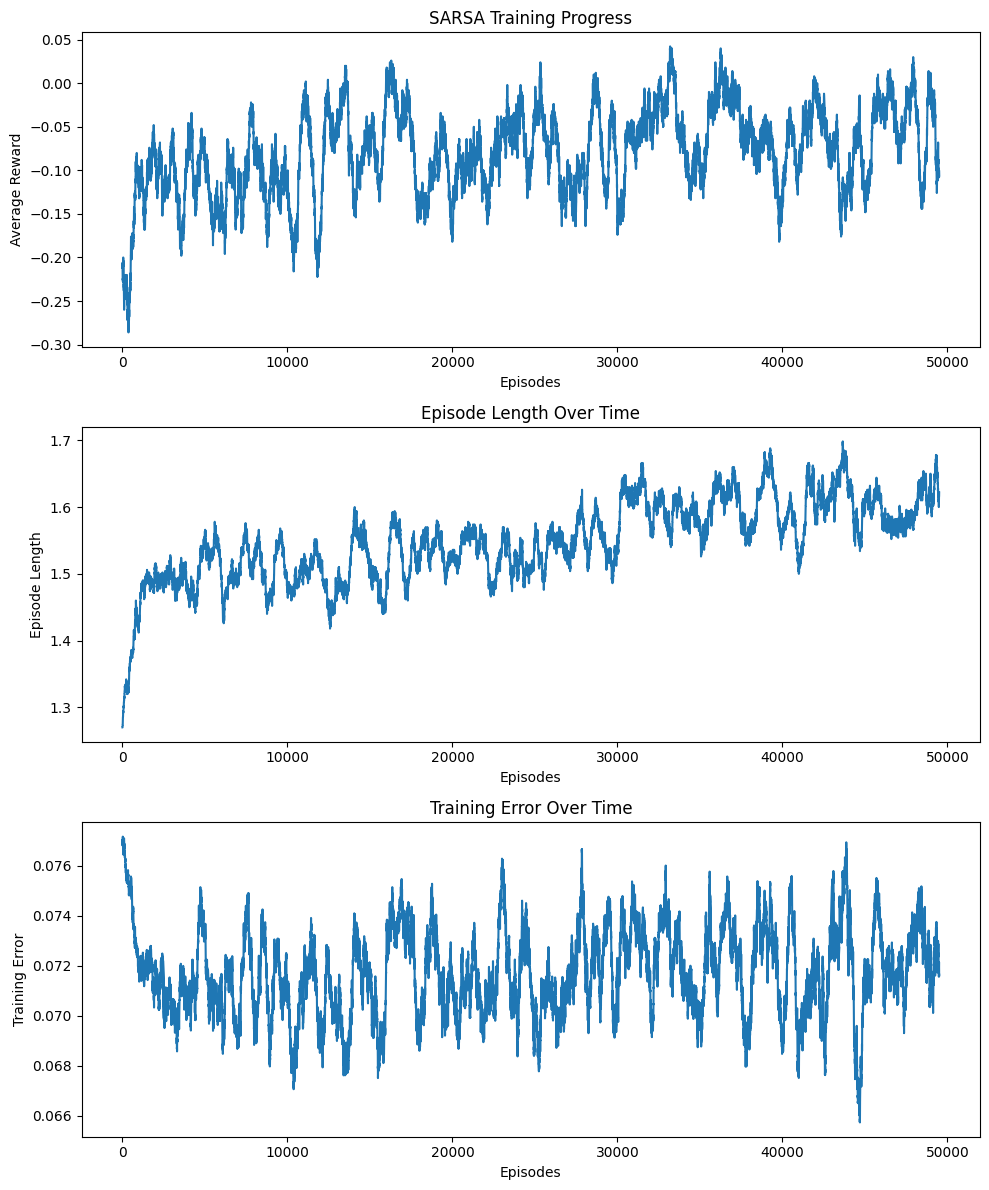

Wins: 411, Draws: 88, Losses: 501
Testing alpha=0.09
Initial Avg Reward: -1.0000
Final Avg Reward: -0.0720
Win Percentage: 41.69%
Loss Percentage: 49.68%
Draw Percentage: 8.64%


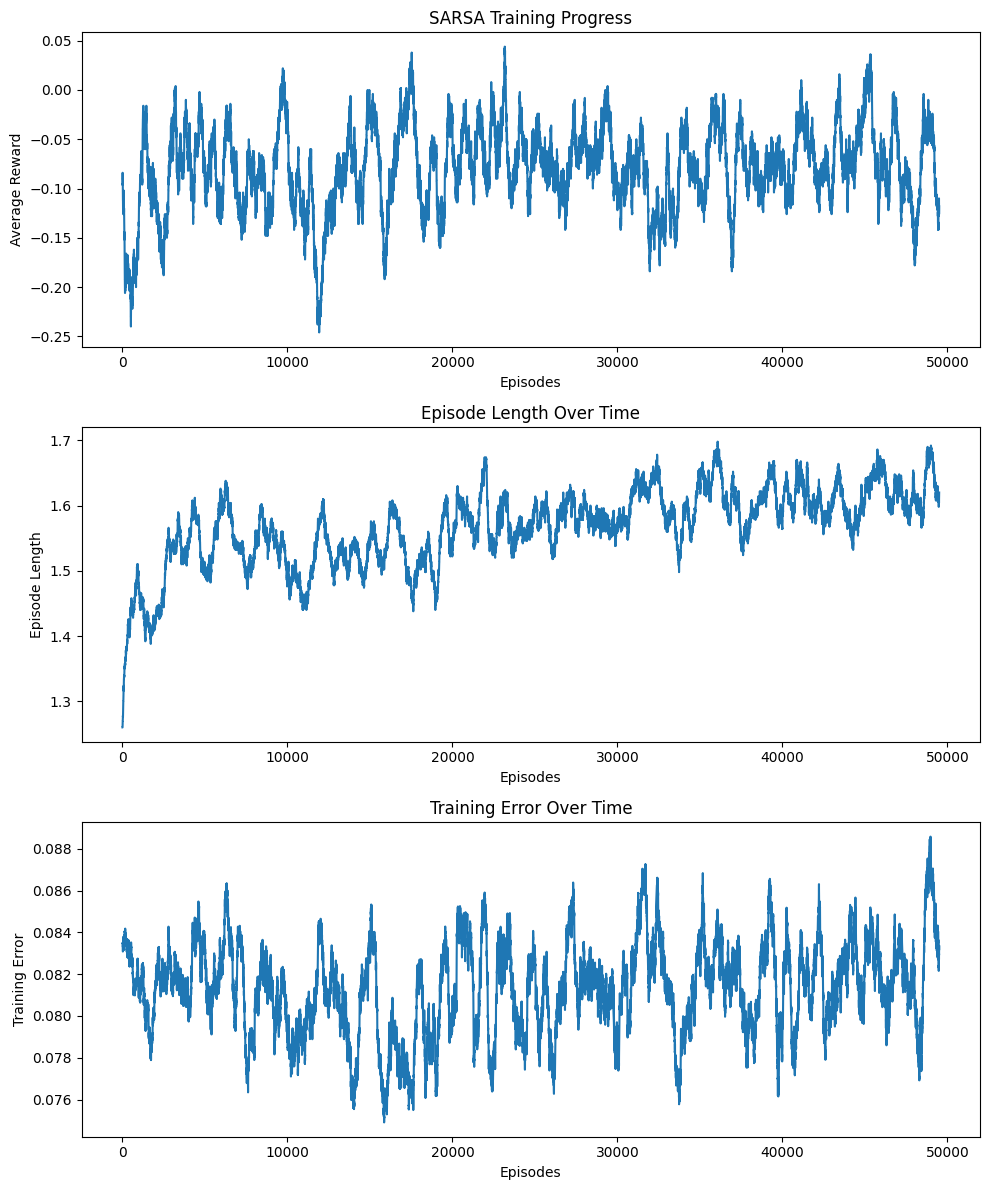

Wins: 376, Draws: 86, Losses: 538
Testing alpha=0.1
Initial Avg Reward: 0.0000
Final Avg Reward: -0.0750
Win Percentage: 41.26%
Loss Percentage: 49.92%
Draw Percentage: 8.82%


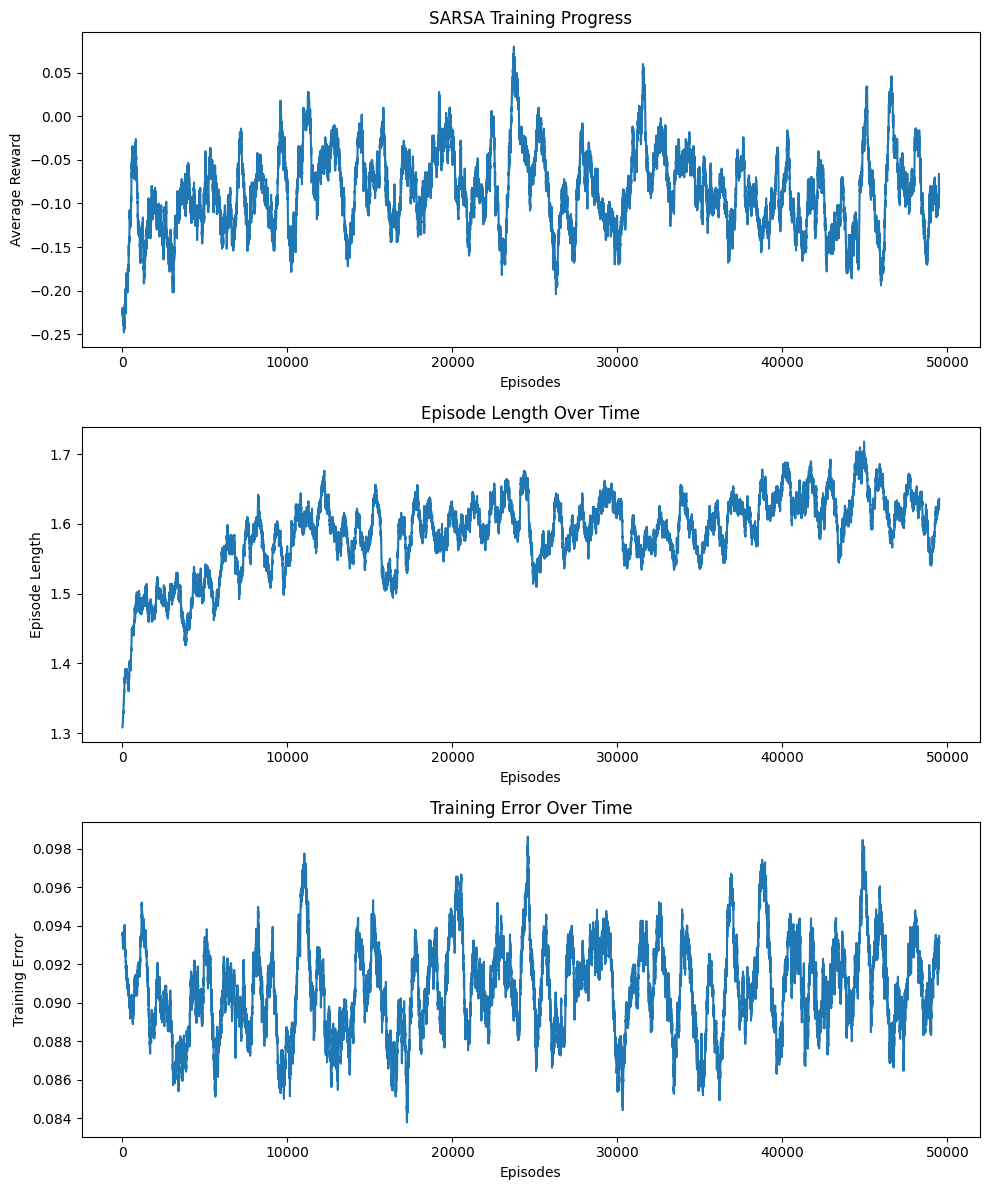

Wins: 407, Draws: 94, Losses: 499
Testing alpha=0.2
Initial Avg Reward: 1.0000
Final Avg Reward: -0.0876
Win Percentage: 41.41%
Loss Percentage: 49.92%
Draw Percentage: 8.67%


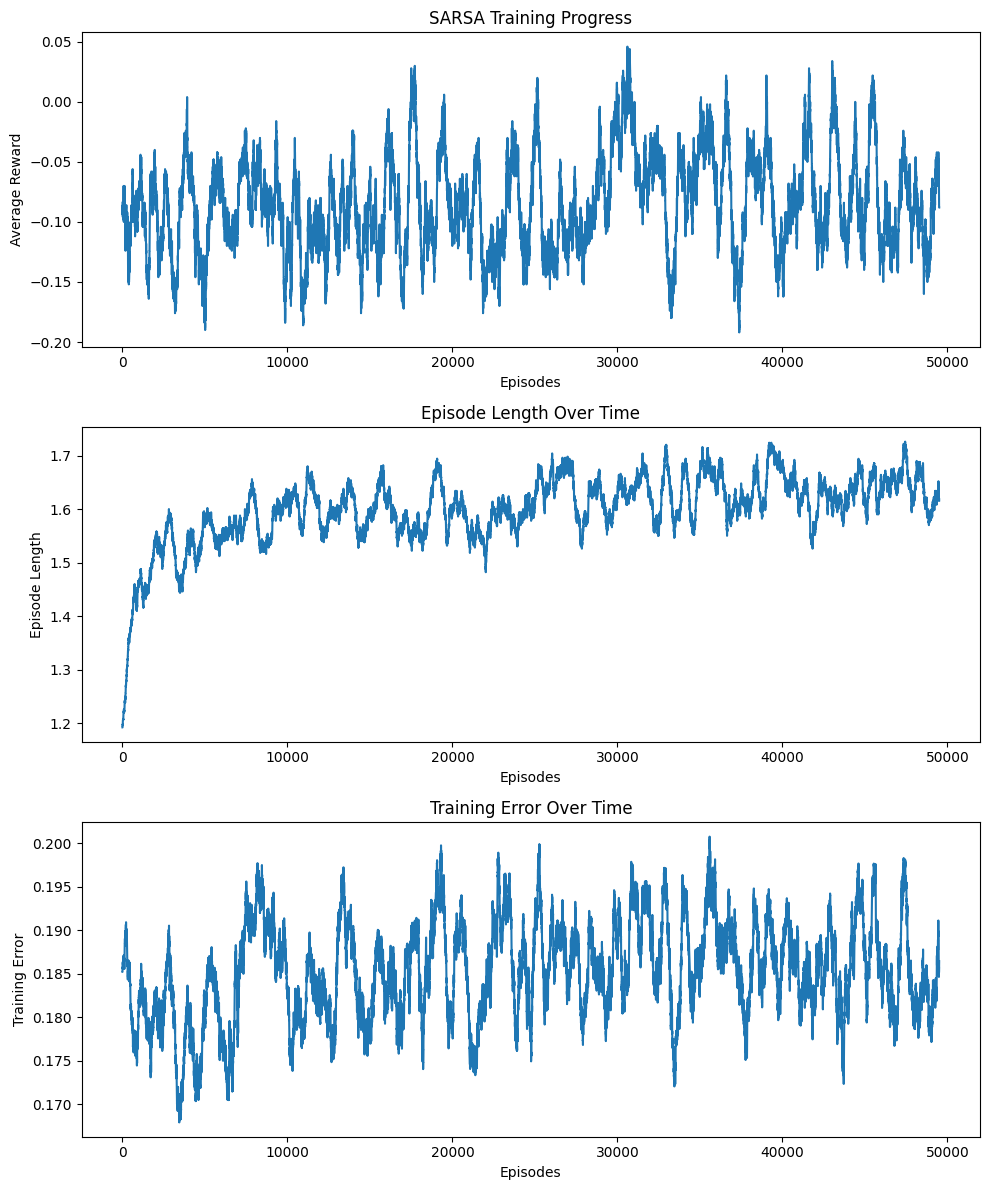

Wins: 428, Draws: 95, Losses: 477


In [12]:
# Experimenting with different learning rates than alpha=0.1
for alpha in [0.06, 0.07, 0.08, 0.09, 0.1, 0.2]:
    print(f"Testing alpha={alpha}")
    Q = sarsa(env, use_epsilon_decay=True, alpha=alpha)
    play_blackjack(Q, env)

Initial Avg Reward: -1.0000
Final Avg Reward: -0.1006
Win Percentage: 40.75%
Loss Percentage: 51.02%
Draw Percentage: 8.23%


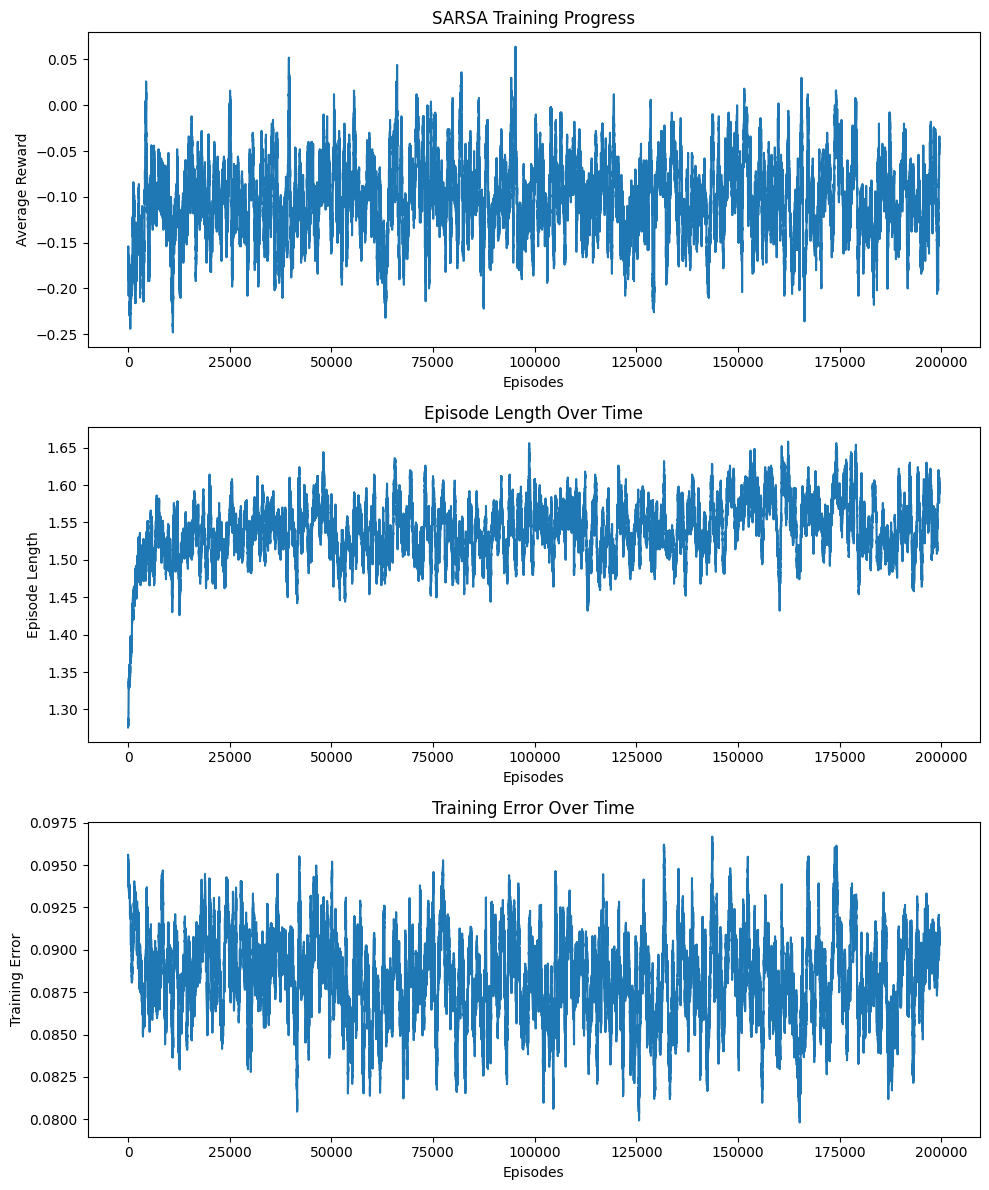

Wins: 426, Draws: 93, Losses: 481


In [13]:
# Increasing training as there are many possible states the agent needs to see - decreases average reward
Q = sarsa(env, episodes=200000)
play_blackjack(Q, env)

Initial Avg Reward: -1.0000
Final Avg Reward: -0.0568
Win Percentage: 42.12%
Loss Percentage: 48.99%
Draw Percentage: 8.89%


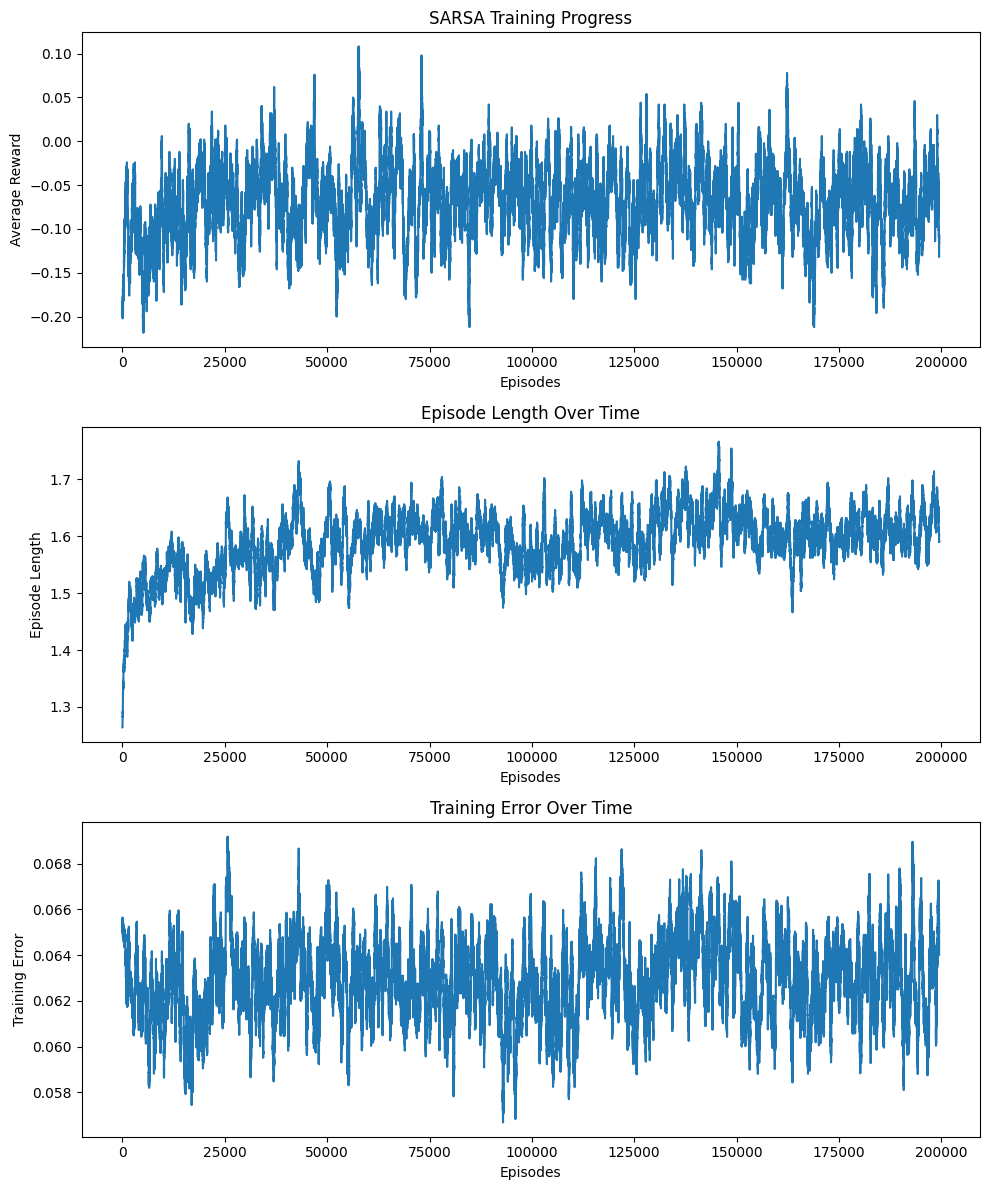

Wins: 438, Draws: 108, Losses: 454


In [21]:
#Putting everything that works together:
Q = sarsa(env, alpha= 0.07, episodes=200000, use_epsilon_decay=True)
play_blackjack(Q, env)

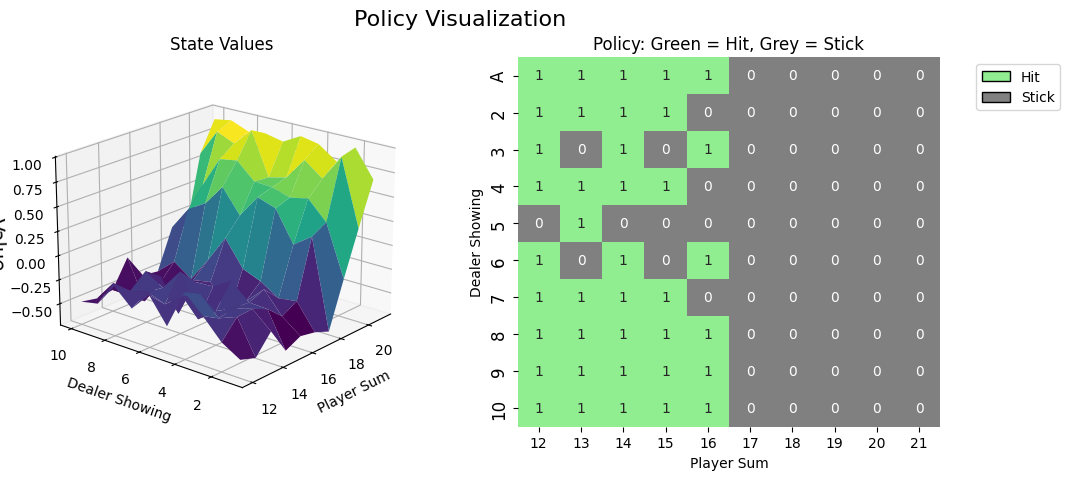

In [54]:
# Evaluating the policy
visualize_policy(Q)

In [ ]:
# Next steps: try different policies during training. Try value iteration.